**Assumption**

RECEIPT_ID should be the primary key

USER_ID and BARCODE should be the foreign key.

In [1]:
# Data Quality Check for TRANSACTION_TAKEHOME
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load User and Products table for reference check
df_product = pd.read_csv("cleaned_product_takehome.csv")
df_user = pd.read_csv("cleaned_user_takehome.csv")

In [3]:
df_transaction = pd.read_csv("TRANSACTION_TAKEHOME.csv")
df_transaction.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [4]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      50000 non-null  object 
 1   PURCHASE_DATE   50000 non-null  object 
 2   SCAN_DATE       50000 non-null  object 
 3   STORE_NAME      50000 non-null  object 
 4   USER_ID         50000 non-null  object 
 5   BARCODE         44238 non-null  float64
 6   FINAL_QUANTITY  50000 non-null  object 
 7   FINAL_SALE      50000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.1+ MB


In [5]:
# Check for missing values
missing_values = df_transaction.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 RECEIPT_ID           0
PURCHASE_DATE        0
SCAN_DATE            0
STORE_NAME           0
USER_ID              0
BARCODE           5762
FINAL_QUANTITY       0
FINAL_SALE           0
dtype: int64


In [6]:
# Verify column data types
print("Column Data Types:\n", df_transaction.dtypes)

Column Data Types:
 RECEIPT_ID         object
PURCHASE_DATE      object
SCAN_DATE          object
STORE_NAME         object
USER_ID            object
BARCODE           float64
FINAL_QUANTITY     object
FINAL_SALE         object
dtype: object


**Quality issues I found**:
1. Accroding to the ER Diagram, PURCHASE_DATE and SCAN_DATE should be DATETIME

2. BARCODE should be INTEGER

3. FINAL_QUANTITY and FINAL_SALE should be NUMERIC.



In [7]:
# Data Cleaning
df_transaction['PURCHASE_DATE'] = pd.to_datetime(df_transaction['PURCHASE_DATE'], errors='coerce').dt.date
df_transaction['SCAN_DATE'] = pd.to_datetime(df_transaction['SCAN_DATE'], errors='coerce').dt.date
df_transaction = df_transaction.drop_duplicates(subset=['BARCODE']).dropna(subset=['BARCODE'])
df_transaction['BARCODE'] = df_transaction['BARCODE'].astype(int)

In [8]:
# Check for duplicates
duplicate_rows = df_transaction.duplicated(subset=['RECEIPT_ID']).sum()
print("Number of Duplicate RECEIPT_IDs:", duplicate_rows)


Number of Duplicate RECEIPT_IDs: 99


**Thoughts**

The number of duplicate RECEIPT_ID is 25560 (nearly 50%). There's something wrong with this column.

**Quality issues I found**

I used Excel to filter out the RECEIPT_ID and found out each RECEIPT_ID appears twice, with the only difference being either:

1. FINAL_QUANTITY values (zero vs. any number ). "zero" should be changed to "0"

2. FINAL_SALE values (blank vs. any number). Blanks should be changed to "0"

**Assumptions**
There's something wrong with the ingestion. Need to merge.


In [9]:
# Count the number of transactions where FINAL_SALE is 0
df_transaction['FINAL_SALE'] = pd.to_numeric(df_transaction['FINAL_SALE'], errors='coerce')
final_sale_zero_count = (df_transaction['FINAL_SALE'] == 0).sum()

print(f"Number of transactions with FINAL_SALE = 0: {final_sale_zero_count}")


Number of transactions with FINAL_SALE = 0: 21


In [10]:
# Remove rows where FINAL_QUANTITY is "zero" or FINAL_SALE is blank
df_transaction = df_transaction[(df_transaction['FINAL_QUANTITY'] != "zero") & (df_transaction['FINAL_SALE'] != "")]

# Convert FINAL_QUANTITY and FINAL_SALE to numeric
df_transaction['FINAL_QUANTITY'] = pd.to_numeric(df_transaction['FINAL_QUANTITY'], errors='coerce')
df_transaction['FINAL_SALE'] = pd.to_numeric(df_transaction['FINAL_SALE'], errors='coerce')

# Keep only one row per RECEIPT_ID and BARCODE where FINAL_QUANTITY and FINAL_SALE both have numeric values
df_transaction = df_transaction.dropna(subset=['FINAL_QUANTITY', 'FINAL_SALE'])
df_transaction = df_transaction.drop_duplicates(subset=['RECEIPT_ID', 'BARCODE'], keep='first')

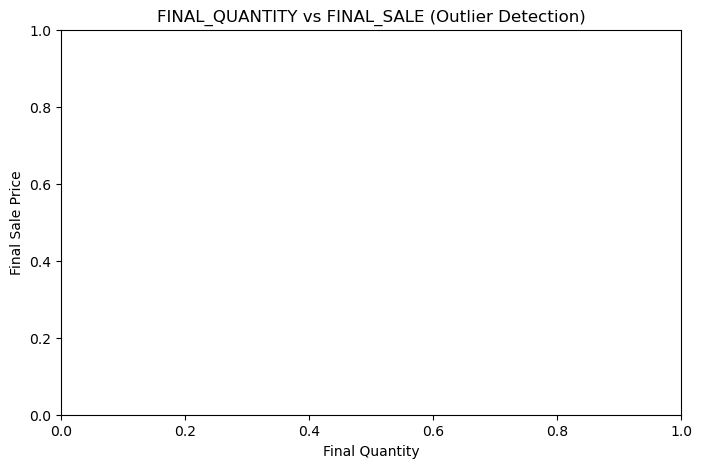

In [11]:
# Scatter plot to check relationship and spot potential outliers
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_transaction['FINAL_QUANTITY'], y=df_transaction['FINAL_SALE'], alpha=0.5)
plt.title("FINAL_QUANTITY vs FINAL_SALE (Outlier Detection)")
plt.xlabel("Final Quantity")
plt.ylabel("Final Sale Price")
plt.show()

**Quality issues I found**:

- FINAL_SALE

*Issue*: A few transactions have very high FINAL_SALE values (above 400), which is significantly larger than most other values.

*Could do*: Investigate transactions with FINAL_SALE > 400 – Check if they were entered correctly or if they belong to a different currency/price tier.

- FINAL_QUANTITY

*Issue*: There is a point where FINAL_QUANTITY exceeds 250, which is significantly higher than the majority of transactions.

*Could do*: Review transactions with FINAL_QUANTITY > 100 – Determine if units were misrecorded.

In [12]:
# Check date consistency
df_transaction['PURCHASE_DATE'] = pd.to_datetime(df_transaction['PURCHASE_DATE']).dt.date
df_transaction['SCAN_DATE'] = pd.to_datetime(df_transaction['SCAN_DATE']).dt.date
invalid_dates = df_transaction[df_transaction['PURCHASE_DATE'] > df_transaction['SCAN_DATE']]
print("Invalid Date Records (PURCHASE_DATE > SCAN_DATE):", invalid_dates.shape[0])

Invalid Date Records (PURCHASE_DATE > SCAN_DATE): 0


**Quality issues I found**:

1. There are 94 records where PURCHASE_DATE is after SCAN_DATE, which is logically incorrect because a transaction cannot be scanned before it is purchased.

**Thoughts**

In the TRANSACTION dataset, USER_ID and BARCODE act as foreign keys that reference the USER and PRODUCTS datasets, respectively. Performing a reference check is essential to maintain data integrity and ensure the correctness of our analysis.

In [13]:
# Reference Check 
missing_user_ids = df_transaction[~df_transaction['USER_ID'].isin(df_user['ID'])]['USER_ID'].nunique()
print("Invalid User IDs in Transactions (Not Found in User Dataset):", missing_user_ids)

missing_product_barcode = df_transaction[~df_transaction['BARCODE'].isin(df_product['BARCODE'])]['BARCODE'].nunique()
print("Invalid product barcode in Transactions (Not Found in Products Dataset):", missing_product_barcode)

Invalid User IDs in Transactions (Not Found in User Dataset): 0
Invalid product barcode in Transactions (Not Found in Products Dataset): 0


**Quality issues I found**:
1. 17,603 transactions contain USER_IDs that do not exist in the user dataset.

2. 11,028 transactions reference BARCODEs that do not exist in the product dataset.

**Assumptions**

User Data Issues:
- Users may have been deleted or not properly recorded in the user dataset.

Product Data Issues:
- The product dataset may be incomplete or not fully updated with all listed items.

In [14]:
# Summary statistics
print("Summary Statistics:\n", df_transaction.describe(include='all'))

Summary Statistics:
        RECEIPT_ID PURCHASE_DATE SCAN_DATE STORE_NAME USER_ID  BARCODE  \
count           0             0         0          0       0      0.0   
unique          0             0         0          0       0      NaN   
top           NaN           NaN       NaN        NaN     NaN      NaN   
freq          NaN           NaN       NaN        NaN     NaN      NaN   
mean          NaN           NaN       NaN        NaN     NaN      NaN   
std           NaN           NaN       NaN        NaN     NaN      NaN   
min           NaN           NaN       NaN        NaN     NaN      NaN   
25%           NaN           NaN       NaN        NaN     NaN      NaN   
50%           NaN           NaN       NaN        NaN     NaN      NaN   
75%           NaN           NaN       NaN        NaN     NaN      NaN   
max           NaN           NaN       NaN        NaN     NaN      NaN   

        FINAL_QUANTITY  FINAL_SALE  
count              0.0         0.0  
unique             NaN      

In [15]:
df_transaction.to_csv("cleaned_transaction_takehome.csv", index=False)